<a href="https://colab.research.google.com/github/fsenchyna/CSC869_Term_Project/blob/main/ProjectBeehive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
import itertools
from itertools import cycle
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/beehives.zip'

In [4]:
!cp "{zip_path}" .
!unzip -q beehives.zip
!rm beehives.zip

In [5]:
train_path = 'beehives/Train'
valid_path = 'beehives/Validate'
test_path = 'beehives/Test'

In [6]:
label_lst=['AntProblem', 'FewVarraoHiveBeetles', 'Healthy', 'HiveBeingRobbed','MissingQueen', 'VarroaSmallHiveBeetles']

# Train
print('For training:')
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications. \
mobilenet.preprocess_input).flow_from_directory(directory=train_path, \
target_size=(224, 224), classes= label_lst, batch_size=10)

# Validate
print('\nFor validation:')
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications. \
mobilenet.preprocess_input).flow_from_directory(directory=valid_path, \
target_size=(224, 224), classes= label_lst, batch_size=10)

#Test
print('\nFor testing:')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications. \
mobilenet.preprocess_input).flow_from_directory(directory=test_path, \
target_size=(224, 224), classes= label_lst, batch_size=10, shuffle=False)


For training:
Found 3566 images belonging to 6 classes.

For validation:
Found 1027 images belonging to 6 classes.

For testing:
Found 579 images belonging to 6 classes.


# Building the classifier/model from scratch



In [7]:
new_model = Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'), 
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense(units=6, activation='softmax'),
])

In [8]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1204230   
Total params: 1,223,622
Trainable params: 1,223,622
Non-trainable params: 0
______________________________________________

In [9]:
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
new_model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
357/357 - 39s - loss: 0.4683 - accuracy: 0.8337 - val_loss: 0.6384 - val_accuracy: 0.7283
Epoch 2/10
357/357 - 5s - loss: 0.2149 - accuracy: 0.9173 - val_loss: 0.5642 - val_accuracy: 0.8140
Epoch 3/10
357/357 - 5s - loss: 0.1463 - accuracy: 0.9467 - val_loss: 0.5114 - val_accuracy: 0.8481
Epoch 4/10
357/357 - 5s - loss: 0.1169 - accuracy: 0.9549 - val_loss: 0.5696 - val_accuracy: 0.8023
Epoch 5/10
357/357 - 5s - loss: 0.0828 - accuracy: 0.9720 - val_loss: 0.6458 - val_accuracy: 0.8286
Epoch 6/10
357/357 - 5s - loss: 0.0745 - accuracy: 0.9734 - val_loss: 0.7770 - val_accuracy: 0.7205
Epoch 7/10
357/357 - 5s - loss: 0.0623 - accuracy: 0.9826 - val_loss: 0.5744 - val_accuracy: 0.8500
Epoch 8/10
357/357 - 5s - loss: 0.0426 - accuracy: 0.9888 - val_loss: 0.6294 - val_accuracy: 0.8277
Epoch 9/10
357/357 - 5s - loss: 0.0323 - accuracy: 0.9930 - val_loss: 0.6539 - val_accuracy: 0.8471
Epoch 10/10
357/357 - 5s - loss: 0.0285 - accuracy: 0.9938 - val_loss: 0.6230 - val_accuracy: 0.855

In [11]:
new_predictions = new_model.predict(x=test_batches, verbose=0).argmax(axis=1)

# Transfer learning on a pretrained model

In [12]:
mobile_net = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [13]:
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [19]:
output = Dense(units=6, activation='softmax')(mobile_net.layers[-6].output)
pretrained_model = Model(inputs=mobile_net.input, outputs=output)

In [20]:
pretrained_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [21]:
pretrained_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
pretrained_model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
357/357 - 24s - loss: 0.1506 - accuracy: 0.9574 - val_loss: 0.4094 - val_accuracy: 0.8676
Epoch 2/10
357/357 - 22s - loss: 0.0483 - accuracy: 0.9863 - val_loss: 0.3812 - val_accuracy: 0.9036
Epoch 3/10
357/357 - 22s - loss: 0.0531 - accuracy: 0.9826 - val_loss: 0.6501 - val_accuracy: 0.8082
Epoch 4/10
357/357 - 22s - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.5269 - val_accuracy: 0.8374
Epoch 5/10
357/357 - 22s - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.3162 - val_accuracy: 0.9231
Epoch 6/10
357/357 - 22s - loss: 0.0194 - accuracy: 0.9930 - val_loss: 0.3371 - val_accuracy: 0.9085
Epoch 7/10
357/357 - 22s - loss: 0.0232 - accuracy: 0.9910 - val_loss: 0.3583 - val_accuracy: 0.9085
Epoch 8/10
357/357 - 22s - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.4217 - val_accuracy: 0.8919
Epoch 9/10
357/357 - 22s - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.5619 - val_accuracy: 0.8637
Epoch 10/10
357/357 - 22s - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.4316 - val_accura

In [23]:
pretrained_predictions = pretrained_model.predict(x=test_batches, verbose=0).argmax(axis=1)

# Evaluation: From Scratch Model vs. Pretrained Model

Citation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [24]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize=(7,7)) # to increase figure(confusion matrix) size

  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title=(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=70)
  plt.yticks(tick_marks,classes)
  thresh = cm.max() / 2.


  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.suptitle(title, fontsize=16)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

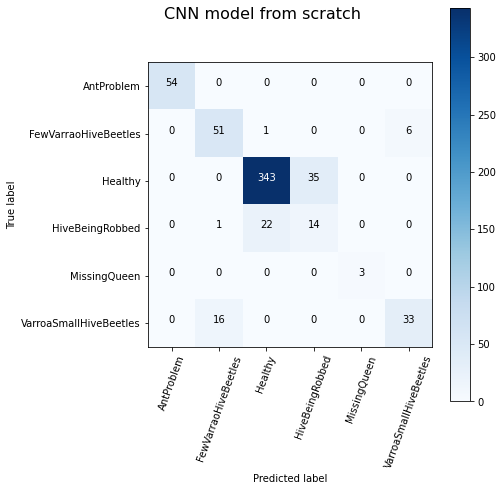

In [25]:
new_cm=confusion_matrix(y_true=test_batches.classes,y_pred=(new_predictions))
plot_confusion_matrix(new_cm, label_lst, title='CNN model from scratch')

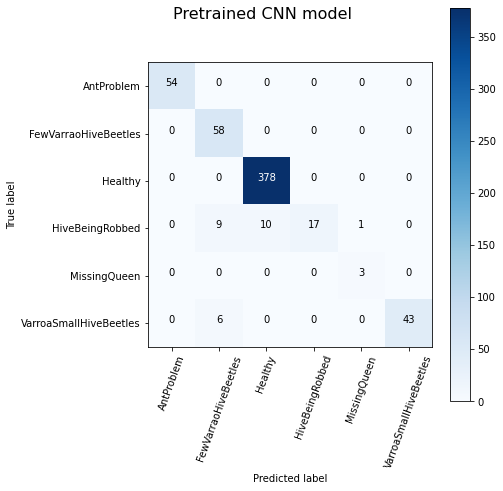

In [26]:
pretrained_cm=confusion_matrix(y_true=test_batches.classes,y_pred=(pretrained_predictions))
plot_confusion_matrix(pretrained_cm, label_lst, title='Pretrained CNN model')

## Calculating the Precision, Recall, Accuracy, and the F1-Score

In [27]:
new_rpt = classification_report(y_true=test_batches.classes,y_pred=(new_predictions), target_names=label_lst)
print('Evaluation measures for CNN model from scratch')
print(new_rpt)

Evaluation measures for CNN model from scratch
                        precision    recall  f1-score   support

            AntProblem       1.00      1.00      1.00        54
  FewVarraoHiveBeetles       0.75      0.88      0.81        58
               Healthy       0.94      0.91      0.92       378
       HiveBeingRobbed       0.29      0.38      0.33        37
          MissingQueen       1.00      1.00      1.00         3
VarroaSmallHiveBeetles       0.85      0.67      0.75        49

              accuracy                           0.86       579
             macro avg       0.80      0.81      0.80       579
          weighted avg       0.88      0.86      0.87       579



In [28]:
pretrained_rpt = classification_report(y_true=test_batches.classes,y_pred=(pretrained_predictions), target_names=label_lst)
print('Evaluation measures for Pretrained CNN model')
print(pretrained_rpt)

Evaluation measures for Pretrained CNN model
                        precision    recall  f1-score   support

            AntProblem       1.00      1.00      1.00        54
  FewVarraoHiveBeetles       0.79      1.00      0.89        58
               Healthy       0.97      1.00      0.99       378
       HiveBeingRobbed       1.00      0.46      0.63        37
          MissingQueen       0.75      1.00      0.86         3
VarroaSmallHiveBeetles       1.00      0.88      0.93        49

              accuracy                           0.96       579
             macro avg       0.92      0.89      0.88       579
          weighted avg       0.96      0.96      0.95       579



# One-vs-the-rest (OvR) multiclass strategy for ROC and AUC

In [29]:
# Compute ROC curve and ROC area for each class
def plot_roc(true_labels, predicted_labels, title):
  y_score = label_binarize(predicted_labels, classes = [0, 1, 2, 3, 4, 5])
  y_test = label_binarize(true_labels, classes = [0, 1, 2, 3, 4, 5])
  # Plot linewidth.
  lw = 2

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(label_lst)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves
  plt.figure(1)
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'pink', 'red'])
  for i, color in zip(range(len(label_lst)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC for class {0} (Area = {1:0.2f})'
             ''.format(label_lst[i], roc_auc[i]))


  plt.suptitle(title, fontsize=16)
  plt.plot([0, 1], [0, 1], 'k-.', lw=lw, )
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right', bbox_to_anchor=(1.95, 0))
  plt.show()

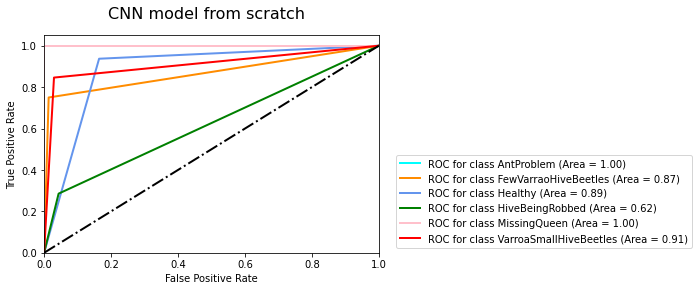

In [30]:
plot_roc(new_predictions, test_batches.classes, title='CNN model from scratch')

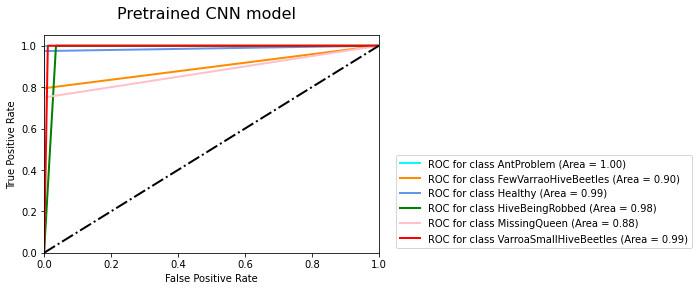

In [31]:
plot_roc(pretrained_predictions, test_batches.classes, title='Pretrained CNN model')